In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
import pandas as pd
import numpy as np

# Specific Kaggle Path
path = '/kaggle/input/mashroom/agaricus-lepiota.data'

# Standard column names for the UCI Mushroom dataset
columns = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
    "gill-attachment", "gill-spacing", "gill-size", "gill-color",
    "stalk-shape", "stalk-root", "stalk-surface-above-ring",
    "stalk-surface-below-ring", "stalk-color-above-ring",
    "stalk-color-below-ring", "veil-type", "veil-color", "ring-number",
    "ring-type", "spore-print-color", "population", "habitat"
]

# Load the data
df = pd.read_csv(path, header=None, names=columns)

print("Data Loaded Successfully!")
print(f"Dataset Shape: {df.shape}")
df.head()
print("\nClass Distribution:\n", df['class'].value_counts())

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum().sum())
print(df)

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum().sum())

Data Loaded Successfully!
Dataset Shape: (8124, 23)

Class Distribution:
 class
e    4208
p    3916
Name: count, dtype: int64

Missing Values:
 0
     class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0        p         x           s         n       t    p               f   
1        e         x           s         y       t    a               f   
2        e         b           s         w       t    l               f   
3        p         x           y         w       t    p               f   
4        e         x           s         g       f    n               f   
...    ...       ...         ...       ...     ...  ...             ...   
8119     e         k           s         n       f    n               a   
8120     e         x           s         n       f    n               a   
8121     e         f           s         n       f    n               a   
8122     p         k           y         n       f    y               f   
8123     e         x         

# **Data Encoding & Correlation**


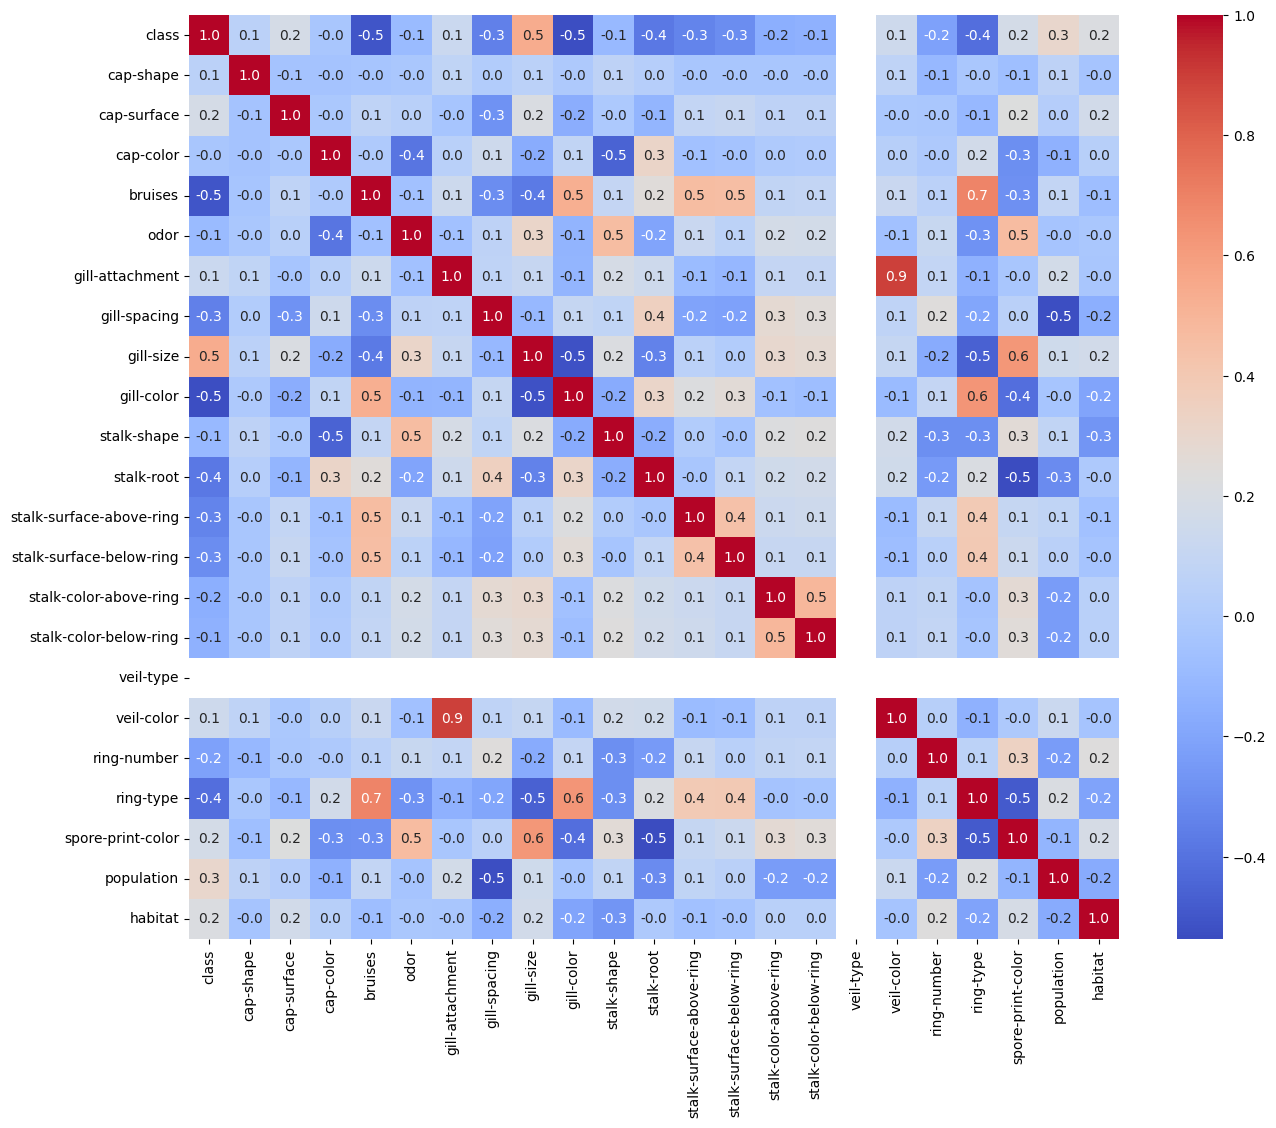

In [3]:
le = LabelEncoder()
df_encoded = df.apply(le.fit_transform)
plt.figure(figsize=(15, 12))
sns.heatmap(df_encoded.corr(), annot=True, fmt=".1f", cmap='coolwarm')
plt.show()

/tmp/ipykernel_17/1770734630.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df, palette='viridis')


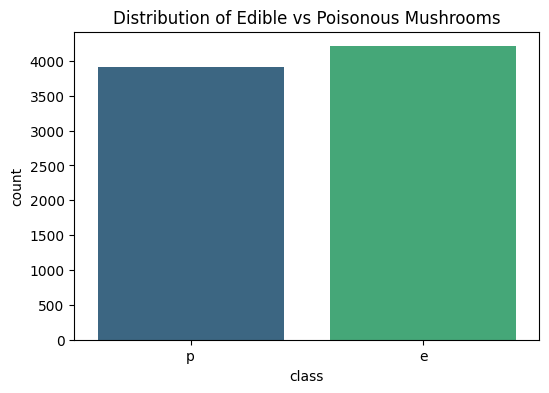

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=df, palette='viridis')
plt.title('Distribution of Edible vs Poisonous Mushrooms')
plt.show()

Manual Decision Tree Accuracy: 0.9828
RF n_estimators 1: Accuracy 1.0000
RF n_estimators 50: Accuracy 1.0000
RF n_estimators 100: Accuracy 1.0000
RF n_estimators 150: Accuracy 1.0000
RF n_estimators 200: Accuracy 1.0000
RF n_estimators 250: Accuracy 1.0000


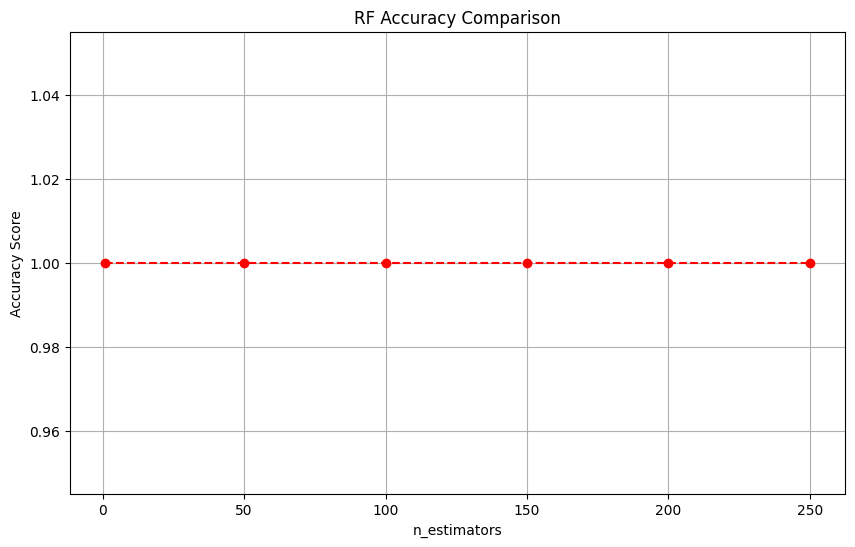

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


le = LabelEncoder()
for col in df.columns:
    df[col] = le.fit_transform(df[col])

X = df.drop('class', axis=1).values
y = df['class'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Manual Decision Tree Implementation ---
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.value = value

class ManualDecisionTree:
    def __init__(self, min_samples_split=2, max_depth=5):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):
        X, y = dataset[:, :-1], dataset[:, -1]
        num_samples, num_features = np.shape(X)
        
        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if best_split["info_gain"] > 0:
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth + 1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth + 1)
                return Node(best_split["feature_index"], best_split["threshold"], left_subtree, right_subtree, best_split["info_gain"])
        
        return Node(value=self.calculate_leaf_value(y))

    def get_best_split(self, dataset, num_samples, num_features):
        best_split = {"info_gain": -float("inf")}
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y_parent, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_info_gain = self.information_gain(y_parent, left_y, right_y)
                    if curr_info_gain > best_split["info_gain"]:
                        best_split = {
                            "feature_index": feature_index, 
                            "threshold": threshold, 
                            "dataset_left": dataset_left, 
                            "dataset_right": dataset_right, 
                            "info_gain": curr_info_gain
                        }
        return best_split

    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([r for r in dataset if r[feature_index] <= threshold])
        dataset_right = np.array([r for r in dataset if r[feature_index] > threshold])
        return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child):
        w_l, w_r = len(l_child) / len(parent), len(r_child) / len(parent)
        return self.entropy(parent) - (w_l * self.entropy(l_child) + w_r * self.entropy(r_child))

    def entropy(self, y):
        labels = np.unique(y)
        ent = 0
        for cls in labels:
            p_cls = len(y[y == cls]) / len(y)
            ent += -p_cls * np.log2(p_cls)
        return ent

    def calculate_leaf_value(self, y):
        y = list(y)
        return max(y, key=y.count)

    def fit(self, X, y):
        dataset = np.concatenate((X, y), axis=1)
        self.root = self.build_tree(dataset)

    def predict(self, X):
        return [self.make_prediction(x, self.root) for x in X]

    def make_prediction(self, x, tree):
        if tree.value is not None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

# --- Model Execution ---
dt_manual = ManualDecisionTree(max_depth=5)
dt_manual.fit(X_train, y_train)
y_pred_manual = dt_manual.predict(X_test)
print(f"Manual Decision Tree Accuracy: {accuracy_score(y_test, y_pred_manual):.4f}")

# --- Random Forest Comparison ---
n_estimators_list = [1, 50, 100, 150, 200, 250]
rf_accuracies = []
y_train_flat = y_train.ravel()

for n in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train_flat)
    acc = accuracy_score(y_test, rf.predict(X_test))
    rf_accuracies.append(acc)
    print(f"RF n_estimators {n}: Accuracy {acc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, rf_accuracies, marker='o', linestyle='--', color='red')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy Score')
plt.title('RF Accuracy Comparison')
plt.grid(True)
plt.show()

# **Model Comparison of Decision Tree and Random Forest**


In [6]:

manual_dt_accuracy = accuracy_score(y_test, y_pred_manual)

best_rf_accuracy = max(rf_accuracies)

print("\n" + "="*40)
print("       FINAL MODEL COMPARISON")
print("="*40)
print(f"Manual Decision Tree Accuracy: {manual_dt_accuracy:.4f}")
print(f"Best Random Forest Accuracy:   {best_rf_accuracy:.4f}")
print("-" * 40)


if best_rf_accuracy > manual_dt_accuracy:
    diff = best_rf_accuracy - manual_dt_accuracy
    print(f"Winner: Random Forest (Better by {diff:.4f})")
elif manual_dt_accuracy > best_rf_accuracy:
    diff = manual_dt_accuracy - best_rf_accuracy
    print(f"Winner: Manual Decision Tree (Better by {diff:.4f})")
else:
    print("Result: Both models performed equally well!")

print("="*40)


       FINAL MODEL COMPARISON
Manual Decision Tree Accuracy: 0.9828
Best Random Forest Accuracy:   1.0000
----------------------------------------
Winner: Random Forest (Better by 0.0172)


# **Confusion Matrix**

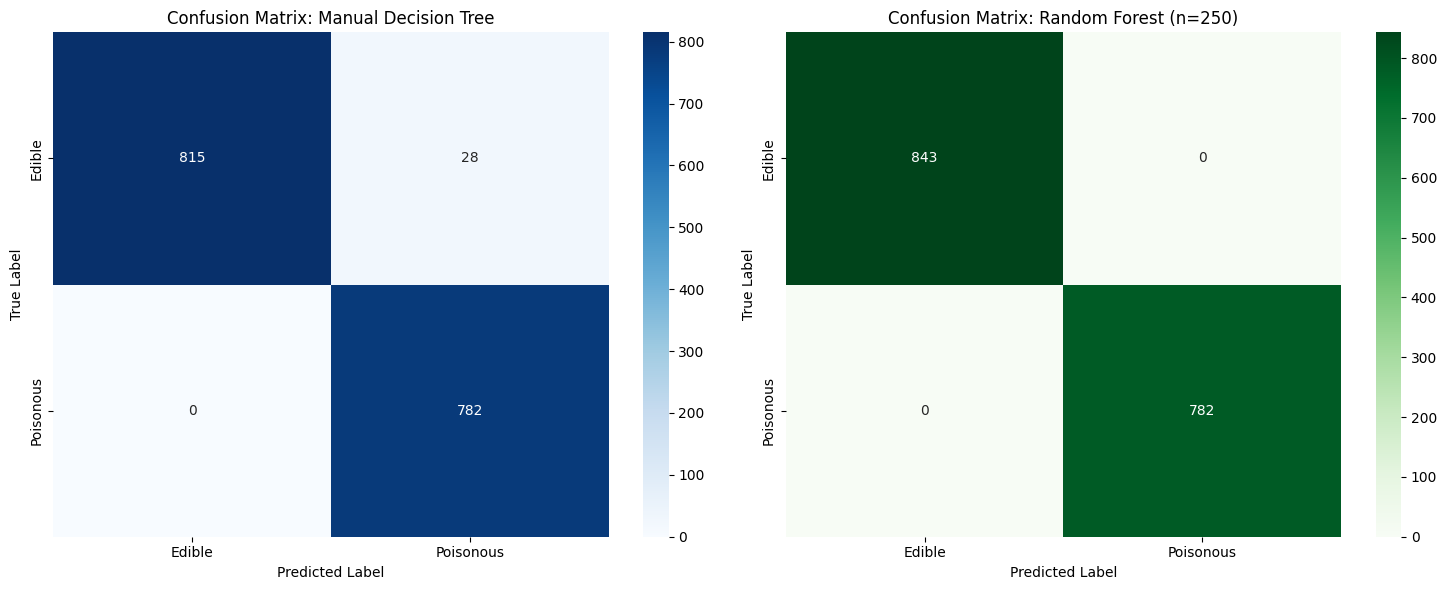


--- Error Analysis ---
Manual DT False Positives (Danger!): 28
Random Forest False Positives (Danger!): 0


In [7]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Generate Confusion Matrices
# Manual Decision Tree
cm_manual_dt = confusion_matrix(y_test, y_pred_manual)

# Random Forest
y_pred_rf = rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# 2. Plotting Side-by-Side
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Manual Decision Tree Plot
sns.heatmap(cm_manual_dt, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix: Manual Decision Tree')
ax[0].set_xlabel('Predicted Label')
ax[0].set_ylabel('True Label')
ax[0].set_xticklabels(['Edible', 'Poisonous'])
ax[0].set_yticklabels(['Edible', 'Poisonous'])

# Random Forest Plot
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title(f'Confusion Matrix: Random Forest (n={n})')
ax[1].set_xlabel('Predicted Label')
ax[1].set_ylabel('True Label')
ax[1].set_xticklabels(['Edible', 'Poisonous'])
ax[1].set_yticklabels(['Edible', 'Poisonous'])

plt.tight_layout()
plt.show()

# 3. Print Summary Stats
print("\n--- Error Analysis ---")
print(f"Manual DT False Positives (Danger!): {cm_manual_dt[0][1]}")
print(f"Random Forest False Positives (Danger!): {cm_rf[0][1]}")